In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import wandb

import math
import torch.nn as nn
from kernel import CannyFilter
#from network.resnet_modified import resnet18
import torchvision.models as models


C:\Users\admin\anaconda3\envs\ocr_engine\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\admin\anaconda3\envs\ocr_engine\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import wandb

In [3]:
wandb.login()

wandb: Currently logged in as: hslrock (use `wandb login --relogin` to force relogin)


True

In [1]:
def index_classes(items):
    idx = {}
    for i in items:
        if (i not in idx):
            idx[i] = len(idx)
    return idx

class MiniImagenet(data.Dataset):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/datasets/mini_imagenet.py)
    **Description**
    The *mini*-ImageNet dataset was originally introduced by Vinyals et al., 2016.
    It consists of 60'000 colour images of sizes 84x84 pixels.
    The dataset is divided in 3 splits of 64 training, 16 validation, and 20 testing classes each containing 600 examples.
    The classes are sampled from the ImageNet dataset, and we use the splits from Ravi & Larochelle, 2017.
    **References**
    1. Vinyals et al. 2016. “Matching Networks for One Shot Learning.” NeurIPS.
    2. Ravi and Larochelle. 2017. “Optimization as a Model for Few-Shot Learning.” ICLR.
    **Arguments**
    * **root** (str) - Path to download the data.
    * **mode** (str, *optional*, default='train') - Which split to use.
        Must be 'train', 'validation', or 'test'.
    * **transform** (Transform, *optional*, default=None) - Input pre-processing.
    * **target_transform** (Transform, *optional*, default=None) - Target pre-processing.
    * **download** (bool, *optional*, default=False) - Download the dataset if it's not available.
    **Example**
    ~~~python
    ~~~
    """
    def __init__(
        self,
        root,
        mode='train',
        transform=None,
        target_transform=None):
        super(MiniImagenet, self).__init__()
        self.root = os.path.expanduser(root)
        if not os.path.exists(self.root):
            os.mkdir(self.root)
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        pickle_file = os.path.join(self.root, 'mini-imagenet-cache-' + mode + '.pkl')

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

   #     self.x = torch.from_numpy(self.data["image_data"]).permute(0, 3, 1, 2).float()
        self.x =self.data["image_data"]
        self.y = np.ones(len(self.x))

        # TODO Remove index_classes from here
        self.class_idx = index_classes(self.data['class_dict'].keys())
        for class_name, idxs in self.data['class_dict'].items():
            for idx in idxs:
                self.y[idx] = self.class_idx[class_name]

    def __getitem__(self, idx):
        data = self.x[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.y[idx]

    def __len__(self):
        return len(self.x)
    
class Classifier(torch.nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
            
        self.classifier = torch.nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, 64, bias=True))

    def forward(self, x):

        x = self.classifier(x)
        return x

NameError: name 'data' is not defined

In [ ]:
data_dir = 'tiny-imagenet-200/'


In [5]:
transform=T.Compose([T.ToTensor(),T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_set=MiniImagenet(root="D:/Dataset/Mini-ImageNet",mode='train',transform=transform)
#torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [30000, 8400])


In [6]:
BS=84
train_dl = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=BS,
                                          shuffle=True,
                                          drop_last=True)
valid_dl = torch.utils.data.DataLoader(dataset=val_set,
                                          batch_size=BS,
                                          shuffle=False,
                                          drop_last=True)

In [15]:
def mix_freq(img,label,b_kernel,e_kernel,lamB=0.5,lamE=0.5):
    with torch.no_grad():
        blured_img=b_kernel(img)
       # edged_img=img-blured_img
        edged_img=e_kernel(img)[1].expand(-1,3,-1,-1)
        idx = torch.randperm(edged_img.shape[0])
        edged_img=edged_img[idx]
        y_b,y_e=label,label[idx]
        mixed_img=lamB*blured_img+lamE*edged_img#+0.2*img,id

    return mixed_img,y_b,y_e,idx
def mixfreq_criterion(criterion, pred, y_a, y_b):
    loss_A=criterion(pred, y_a)
    print(loss_A)
    print(loss_B)
    loss_B=criterion(pred, y_b)

    return loss_A+loss_B

In [8]:
img,label=next(iter(train_dl))
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)
mixed_img,_,_,idx=mix_freq(img,label,blur_kernel,edge_kernel,lamB=0.5,lamE=0.5)

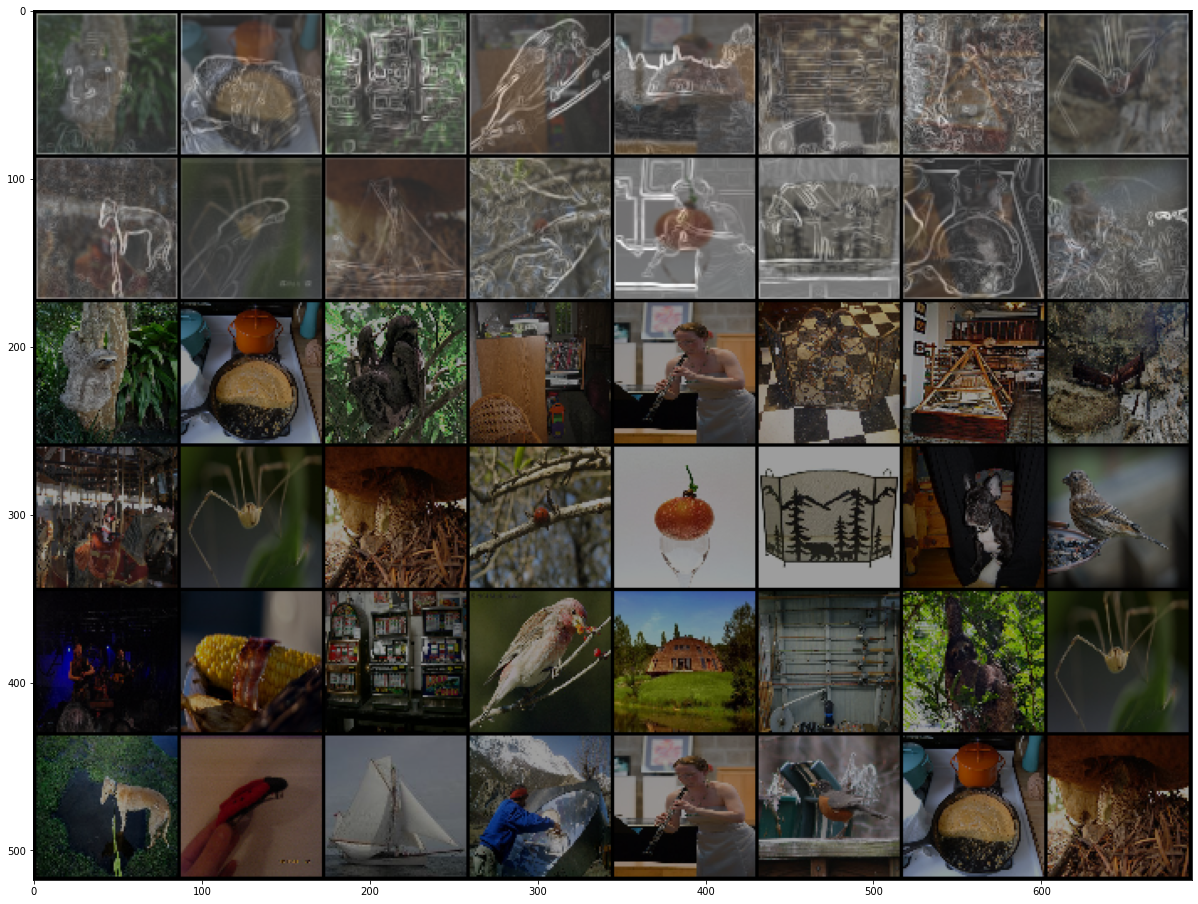

In [9]:
import torchvision
mixed_img,_,_,idx=mix_freq(img,label,blur_kernel,edge_kernel,lamB=0.5,lamE=0.5)
grid_img = torchvision.utils.make_grid(torch.cat([mixed_img[0:16],img[0:16],img[idx[0:16]]]).detach(), nrow=8,normalize=True)
#gt=[label_name[x.long()] for x in LABELS]
plt.figure(figsize=(24,16))
#plt.title(gt)
plt.imshow(grid_img.permute(1, 2, 0))

In [11]:
ft_net=models.resnet18(num_classes=60,)
#ft_net=resnet18(pretrained=False)
#classifier_net=Classifier()
embed_consistency_loss=nn.MSELoss()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD((list(ft_net.parameters()) + list(classifier_net.parameters())), lr=0.1, momentum=0.9,
#                      weight_decay=1e-4)
optimizer = optim.SGD(ft_net.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)

device='cuda'

In [13]:
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True,use_cuda=True)
blur_kernel.to(device)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False,use_cuda=True)
edge_kernel.to(device)

ft_net.to(device)
for batch_idx,(img,label) in enumerate(train_dl):
        #Zero_grad_Optimizer
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device).long()
     
        mixed_img,labelA,labelB,idx=mix_freq(img,label,b_kernel=blur_kernel,e_kernel=edge_kernel)

        #Model Forward
        overall_output=ft_net(mixed_img)
        #blur_,edge_,union=ft_net(torch.cat([img,mixed_img]))

        
        lf_img,lf_mixed=torch.split(blur_,BS)
        ft_img,ft_mixed=torch.split(edge_,BS)
        union_img,union_mixed=torch.split(union,BS)
        
        #
        blur_consist_loss=embed_consistency_loss(lf_img,lf_mixed)
        edge_consist_loss=embed_consistency_loss(ft_img,ft_mixed[idx])

        blur_output=classifier_net(lf_mixed)
        edge_output=classifier_net(ft_mixed)
        overall_output=classifier_net(union_mixed)

        #blur_loss=criterion(blur_output,labelA)
        #edge_loss=criterion(edge_output,labelB)
        #loss=mixfreq_criterion(criterion,overall_output,labelA,labelB)
        break

In [ ]:
mixfreq_criterion(criterion,overall_output,labelA,labelB)

In [14]:
overall_output

tensor([[ 0.6298,  0.9460,  0.7110,  ...,  0.2225, -0.3086, -0.2383],
        [ 0.3272,  0.4156,  0.1888,  ...,  0.0605, -0.1792, -0.0339],
        [ 0.4392,  0.4352,  0.4232,  ...,  0.0603,  0.0234, -0.1788],
        ...,
        [ 0.3353,  0.7335,  0.3004,  ...,  0.2652,  0.0325, -0.2708],
        [ 0.4161,  0.4932,  0.2826,  ...,  0.0201, -0.4355, -0.2913],
        [ 0.4367,  0.7398,  0.1357,  ...,  0.1478, -0.3308, -0.2023]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
loss

In [11]:
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True,use_cuda=True)
blur_kernel.to(device)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False,use_cuda=True)
edge_kernel.to(device)

ft_net.to(device)
#classifier_net.to(device)

wandb.init(project="Augmentation_Strategy")
wandb.run.name = "MixFreq_Reproduce"
wandb.run.save()
max_val_accuracy=0
for epoch in tqdm(range(100),leave=False):
    print(f'Epochs : {epoch+1}')
    ft_net.train()
    #classifier_net.train()
    avg_train_loss=0
   # avg_edge_loss=0
   # avg_blur_loss=0
    #avg_union_loss=0
    #avg_edge_consistency_loss=0
  #  avg_blur_consistency_loss=0
    correct=0
    total=0
    for batch_idx,(img,label) in enumerate(train_dl):
        #Zero_grad_Optimizer
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device).long()
        if epoch<60:            
            mixed_img,labelA,labelB,idx=mix_freq(img,label,b_kernel=blur_kernel,e_kernel=edge_kernel)
            
            #Model Forward
            overall_output=ft_net(mixed_img)
            #blur_,edge_,union=ft_net(torch.cat([img,mixed_img]))
            
            #lf_img,lf_mixed=torch.split(blur_,BS)
            #ft_img,ft_mixed=torch.split(edge_,BS)
            #union_img,union_mixed=torch.split(union,BS)
            
            #blur_consist_loss=embed_consistency_loss(lf_img,lf_mixed)
            #edge_consist_loss=embed_consistency_loss(ft_img,ft_mixed[idx])
            
            #blur_output=classifier_net(lf_mixed)
            #edge_output=classifier_net(ft_mixed)
            #overall_output=classifier_net(union_mixed)

            #blur_loss=criterion(blur_output,labelA)
            #edge_loss=criterion(edge_output,labelB)
            loss=mixfreq_criterion(criterion,overall_output,labelA,labelB)
            
            #loss=(blur_loss *0.5)+(edge_loss*0.5)+(mixed_loss*0.5)+(0.01*edge_consist_loss)+(0.01*blur_consist_loss)
            #loss=mixed_loss
            #Measure Loss
            loss.backward()
        else:
            overall_output=ft_net(img)
            #lf_,ft_,union=ft_net(img)
            #blur_output=classifier_net(lf_)
            #edge_output=classifier_net(ft_)
            #overall_output=classifier_net(union)
            
            #blur_loss=criterion(blur_output,label)
            #edge_loss=criterion(edge_output,label)
            loss=criterion(overall_output,label)
            #loss=blur_loss*0.5+edge_loss*0.5+mixed_loss*0.5
            #loss=mixed_loss
            loss.backward()
            

        #Update Parameters
        optimizer.step()
        avg_train_loss+=loss.item()
        #avg_edge_loss+=edge_loss.item()
        #avg_blur_loss+=blur_loss.item()
        #avg_union_loss+=mixed_loss.item()
        #avg_edge_consistency_loss=edge_consist_loss.item()
        #avg_blur_consistency_loss=blur_consist_loss.item()
        if batch_idx % 50==0:
            wandb.log({
                "Train Loss": avg_train_loss/(batch_idx+1),
                #"Blur Loss": avg_edge_loss/(batch_idx+1),
               # "Edge Loss": avg_blur_loss/(batch_idx+1),
             #   "Blur_consistency Loss": avg_edge_consistency_loss/(batch_idx+1),
            #    "Edge_consistency Loss": avg_blur_consistency_loss/(batch_idx+1),
            #    "Union Loss": avg_union_loss/(batch_idx+1)
            })
    ft_net.eval()
#     classifier_net.eval()   
    valid_loss=0
    correct=0
    total=0

    for batch_idx,(img,label) in enumerate(valid_dl):

        img=img.to(device)
        label=label.to(device).long()
        output=ft_net(img)
        #_,_,union=ft_net(img)

        #output=classifier_net(union)
        
        #Measure Loss
        loss=criterion(output,label)
        valid_loss+=loss.item()

        _, predicted = torch.max(output.data, 1)
        total+=label.size()[0]
        correct += (predicted == label).sum().item()
    avg_valid_loss=valid_loss/(len(valid_dl))
    wandb.log({
        "epoch": epoch,
        "Val Accuracy": correct/total,
        "Val Loss": avg_valid_loss})
    if (correct/total)>max_val_accuracy:
        max_val_accuracy=correct/total
        print('Validation Result is better, saving the new model')
        torch.save(ft_net.state_dict(),"models/disentangle_mix_freq_ft_net.h")
        torch.save(classifier_net.state_dict(),"models/disentangle_mix_freq_classifier_net.h")


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epochs : 1


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [32]:
lf_img,lf_mixed=torch.split(lf_,BS)
ft_img,ft_mixed=torch.split(lf_,BS)
union_img,union_mixed=torch.split(lf_,BS)
lf_cons=embed_consistency_loss(lf_img,lf_mixed)
hf_cons=embed_consistency_loss(ft_img,ft_mixed[idx])


tensor(0.3452, device='cuda:0', grad_fn=<MseLossBackward0>)

In [33]:
ft_mixed[idx]

tensor([[0.2274, 0.2870, 0.7001,  ..., 0.5871, 0.9189, 0.5462],
        [0.4193, 0.7220, 0.5532,  ..., 0.7101, 0.3957, 0.5139],
        [1.8997, 2.3445, 1.5491,  ..., 1.4354, 2.1130, 0.8970],
        ...,
        [0.6338, 0.1212, 0.4770,  ..., 1.0206, 0.4214, 0.4289],
        [0.4513, 0.2381, 0.1305,  ..., 0.6696, 0.4382, 0.3750],
        [0.4320, 0.7429, 0.3790,  ..., 0.7014, 0.6516, 0.4882]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [34]:
ft_mixed

tensor([[0.3905, 0.0744, 0.4952,  ..., 0.5970, 0.3197, 0.5321],
        [0.8681, 0.5961, 0.2383,  ..., 0.7916, 0.4950, 0.5026],
        [0.6878, 0.5851, 0.4981,  ..., 0.3431, 0.2660, 0.5180],
        ...,
        [0.4206, 0.4410, 0.5795,  ..., 0.5387, 0.5834, 0.9461],
        [1.6131, 0.6934, 0.5483,  ..., 0.6559, 0.7693, 0.3067],
        [0.1931, 0.3302, 0.7153,  ..., 0.9365, 0.7554, 0.3684]],
       device='cuda:0', grad_fn=<SplitBackward0>)

In [28]:
embed_consistency_loss=nn.MSELoss()

In [ ]:
embed_consistency_loss(lf_im)

In [25]:
lf_img.shape

torch.Size([42, 256])

In [15]:
mixed_img.shape

torch.Size([84, 3, 84, 84])

In [19]:
torch.cat([img,mixed_img]).shape

torch.Size([168, 3, 84, 84])

In [ ]:
img_copy=img.copy

In [11]:
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True,use_cuda=True)
blur_kernel.to(device)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False,use_cuda=True)
edge_kernel.to(device)

ft_net.to(device)
classifier_net.to(device)

wandb.init(project="Augmentation_Strategy")
wandb.run.name = "MixFreq_Disentangle_extra_loss"
wandb.run.save()
max_val_accuracy=0
for epoch in tqdm(range(100),leave=False):
    print(f'Epochs : {epoch+1}')
    ft_net.train()
    classifier_net.train()
    avg_train_loss=0
    avg_edge_loss=0
    avg_blur_loss=0
    avg_union_loss=0
    correct=0
    total=0
    for batch_idx,(img,label) in enumerate(train_dl):
        #Zero_grad_Optimizer
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device).long()
        if epoch<60:
            img,labelA,labelB=mix_freq(img,label,b_kernel=blur_kernel,e_kernel=edge_kernel)
            
            
            lf_,ft_,union=ft_net(img)
            blur_output=classifier_net(lf_)
            edge_output=classifier_net(ft_)
            overall_output=classifier_net(union)

            blur_loss=criterion(blur_output,labelA)
            edge_loss=criterion(edge_output,labelB)
            mixed_loss=mixfreq_criterion(criterion,overall_output,labelA,labelB)
            
            loss=blur_loss*0.5+edge_loss*0.5+mixed_loss*0.5
            #Measure Loss
            loss.backward()
        else:
            lf_,ft_,union=ft_net(img)
            blur_output=classifier_net(lf_)
            edge_output=classifier_net(ft_)
            overall_output=classifier_net(union)
            
            blur_loss=criterion(blur_output,label)
            edge_loss=criterion(edge_output,label)
            mixed_loss=criterion(overall_output,label)
            loss=blur_loss*0.5+edge_loss*0.5+mixed_loss*0.5
            loss.backward()
            

        #Update Parameters
        optimizer.step()
        avg_train_loss+=loss.item()
        avg_edge_loss+=blur_loss.item()
        avg_blur_loss+=edge_loss.item()
        avg_union_loss+=mixed_loss.item()
        if batch_idx % 50==0:
            wandb.log({
                "Train Loss": avg_train_loss/(batch_idx+1),
                "Blur Loss": avg_edge_loss/(batch_idx+1),
                "Edge Loss": avg_blur_loss/(batch_idx+1),
                "Union Loss": avg_union_loss/(batch_idx+1)
            })
    ft_net.eval()
    classifier_net.eval()   
    valid_loss=0
    correct=0
    total=0

    for batch_idx,(img,label) in enumerate(valid_dl):

        img=img.to(device)
        label=label.to(device).long()

        _,_,union=ft_net(img)

        output=classifier_net(union)
        
        #Measure Loss
        loss=criterion(output,label)
        valid_loss+=loss.item()

        _, predicted = torch.max(output.data, 1)
        total+=label.size()[0]
        correct += (predicted == label).sum().item()
    avg_valid_loss=valid_loss/(len(valid_dl))
    wandb.log({
        "epoch": epoch,
        "Val Accuracy": correct/total,
        "Val Loss": avg_valid_loss})
    if (correct/total)>max_val_accuracy:
        max_val_accuracy=correct/total
        print('Validation Result is better, saving the new model')
        torch.save(ft_net.state_dict(),"models/mix_freq_ft_net.h")
        torch.save(classifier_net.state_dict(),"models/mix_freq_classifier_net.h")


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epochs : 1


  1%|▊                                                                                 | 1/100 [00:35<58:40, 35.56s/it]

Validation Result is better, saving the new model
Epochs : 2


  2%|█▋                                                                                | 2/100 [01:08<55:08, 33.76s/it]

Epochs : 3


  3%|██▍                                                                               | 3/100 [01:43<55:38, 34.42s/it]

Validation Result is better, saving the new model
Epochs : 4


  4%|███▎                                                                              | 4/100 [02:18<55:19, 34.58s/it]

Validation Result is better, saving the new model
Epochs : 5


  5%|████                                                                              | 5/100 [02:53<54:58, 34.72s/it]

Validation Result is better, saving the new model
Epochs : 6


  6%|████▉                                                                             | 6/100 [03:26<53:54, 34.41s/it]

Validation Result is better, saving the new model
Epochs : 7


  7%|█████▋                                                                            | 7/100 [04:00<52:48, 34.07s/it]

Validation Result is better, saving the new model
Epochs : 8


  8%|██████▌                                                                           | 8/100 [04:32<51:32, 33.62s/it]

Validation Result is better, saving the new model
Epochs : 9


  9%|███████▍                                                                          | 9/100 [05:05<50:22, 33.21s/it]

Epochs : 10


 10%|████████                                                                         | 10/100 [05:37<49:32, 33.03s/it]

Validation Result is better, saving the new model
Epochs : 11


 11%|████████▉                                                                        | 11/100 [06:10<48:43, 32.85s/it]

Epochs : 12


 12%|█████████▋                                                                       | 12/100 [06:42<47:59, 32.72s/it]

Validation Result is better, saving the new model
Epochs : 13


 13%|██████████▌                                                                      | 13/100 [07:15<47:15, 32.60s/it]

Validation Result is better, saving the new model
Epochs : 14


 14%|███████████▎                                                                     | 14/100 [07:46<46:21, 32.34s/it]

Epochs : 15


 15%|████████████▏                                                                    | 15/100 [08:18<45:46, 32.31s/it]

Validation Result is better, saving the new model
Epochs : 16


 16%|████████████▉                                                                    | 16/100 [08:51<45:08, 32.24s/it]

Epochs : 17


 17%|█████████████▊                                                                   | 17/100 [09:23<44:38, 32.27s/it]

Epochs : 18


 18%|██████████████▌                                                                  | 18/100 [09:56<44:15, 32.39s/it]

Validation Result is better, saving the new model
Epochs : 19


 19%|███████████████▍                                                                 | 19/100 [10:28<43:36, 32.31s/it]

Epochs : 20


 20%|████████████████▏                                                                | 20/100 [11:00<42:58, 32.24s/it]

Epochs : 21


 21%|█████████████████                                                                | 21/100 [11:32<42:29, 32.28s/it]

Validation Result is better, saving the new model
Epochs : 22


 22%|█████████████████▊                                                               | 22/100 [12:04<41:56, 32.27s/it]

Epochs : 23


 23%|██████████████████▋                                                              | 23/100 [12:36<41:20, 32.22s/it]

Epochs : 24


 24%|███████████████████▍                                                             | 24/100 [13:09<40:46, 32.19s/it]

Epochs : 25


 25%|████████████████████▎                                                            | 25/100 [13:41<40:20, 32.27s/it]

Validation Result is better, saving the new model
Epochs : 26


 26%|█████████████████████                                                            | 26/100 [14:17<41:12, 33.41s/it]

Epochs : 27


 27%|█████████████████████▊                                                           | 27/100 [14:49<40:10, 33.02s/it]

Epochs : 28


 28%|██████████████████████▋                                                          | 28/100 [15:21<39:15, 32.72s/it]

Epochs : 29


 29%|███████████████████████▍                                                         | 29/100 [15:54<38:34, 32.59s/it]

Epochs : 30


 30%|████████████████████████▎                                                        | 30/100 [16:26<37:53, 32.48s/it]

Epochs : 31


 31%|█████████████████████████                                                        | 31/100 [16:58<37:13, 32.36s/it]

Epochs : 32


 32%|█████████████████████████▉                                                       | 32/100 [17:30<36:34, 32.28s/it]

Epochs : 33


 33%|██████████████████████████▋                                                      | 33/100 [18:02<36:02, 32.28s/it]

Epochs : 34


 34%|███████████████████████████▌                                                     | 34/100 [18:34<35:27, 32.24s/it]

Epochs : 35


 35%|████████████████████████████▎                                                    | 35/100 [19:07<34:56, 32.26s/it]

Validation Result is better, saving the new model
Epochs : 36


 36%|█████████████████████████████▏                                                   | 36/100 [19:39<34:25, 32.28s/it]

Epochs : 37


 37%|█████████████████████████████▉                                                   | 37/100 [20:11<33:53, 32.28s/it]

Epochs : 38


 38%|██████████████████████████████▊                                                  | 38/100 [20:45<33:55, 32.83s/it]

Epochs : 39


 39%|███████████████████████████████▌                                                 | 39/100 [21:18<33:16, 32.73s/it]

Epochs : 40


 40%|████████████████████████████████▍                                                | 40/100 [21:50<32:34, 32.57s/it]

Epochs : 41


 41%|█████████████████████████████████▏                                               | 41/100 [22:23<32:01, 32.56s/it]

Epochs : 42


 42%|██████████████████████████████████                                               | 42/100 [22:55<31:27, 32.54s/it]

Epochs : 43


 43%|██████████████████████████████████▊                                              | 43/100 [23:28<30:53, 32.51s/it]

Epochs : 44


 44%|███████████████████████████████████▋                                             | 44/100 [24:00<30:24, 32.57s/it]

Validation Result is better, saving the new model
Epochs : 45


 45%|████████████████████████████████████▍                                            | 45/100 [24:33<30:00, 32.74s/it]

Epochs : 46


 46%|█████████████████████████████████████▎                                           | 46/100 [25:09<30:20, 33.72s/it]

Epochs : 47


 47%|██████████████████████████████████████                                           | 47/100 [25:42<29:34, 33.48s/it]

Epochs : 48


 48%|██████████████████████████████████████▉                                          | 48/100 [26:15<28:44, 33.16s/it]

Epochs : 49


 49%|███████████████████████████████████████▋                                         | 49/100 [26:47<28:00, 32.94s/it]

Validation Result is better, saving the new model
Epochs : 50


 50%|████████████████████████████████████████▌                                        | 50/100 [27:19<27:17, 32.75s/it]

Epochs : 51


 51%|█████████████████████████████████████████▎                                       | 51/100 [27:52<26:35, 32.57s/it]

Epochs : 52


 52%|██████████████████████████████████████████                                       | 52/100 [28:24<26:01, 32.54s/it]

Epochs : 53


 53%|██████████████████████████████████████████▉                                      | 53/100 [28:56<25:25, 32.47s/it]

Epochs : 54


 54%|███████████████████████████████████████████▋                                     | 54/100 [29:29<24:51, 32.43s/it]

Validation Result is better, saving the new model
Epochs : 55


 55%|████████████████████████████████████████████▌                                    | 55/100 [30:01<24:15, 32.34s/it]

Epochs : 56


 56%|█████████████████████████████████████████████▎                                   | 56/100 [30:33<23:40, 32.28s/it]

Epochs : 57


 57%|██████████████████████████████████████████████▏                                  | 57/100 [31:05<23:06, 32.24s/it]

Epochs : 58


 58%|██████████████████████████████████████████████▉                                  | 58/100 [31:37<22:31, 32.19s/it]

Epochs : 59


 59%|███████████████████████████████████████████████▊                                 | 59/100 [32:10<22:01, 32.24s/it]

Epochs : 60


 60%|████████████████████████████████████████████████▌                                | 60/100 [32:42<21:26, 32.16s/it]

Epochs : 61


 61%|█████████████████████████████████████████████████▍                               | 61/100 [33:03<18:53, 29.08s/it]

Validation Result is better, saving the new model
Epochs : 62


 62%|██████████████████████████████████████████████████▏                              | 62/100 [33:25<17:04, 26.95s/it]

Validation Result is better, saving the new model
Epochs : 63


 63%|███████████████████████████████████████████████████                              | 63/100 [33:47<15:40, 25.42s/it]

Epochs : 64


 64%|███████████████████████████████████████████████████▊                             | 64/100 [34:09<14:39, 24.42s/it]

Validation Result is better, saving the new model
Epochs : 65


 65%|████████████████████████████████████████████████████▋                            | 65/100 [34:31<13:49, 23.71s/it]

Epochs : 66


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [34:53<13:06, 23.14s/it]

Epochs : 67


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [35:15<12:33, 22.83s/it]

Epochs : 68


 68%|███████████████████████████████████████████████████████                          | 68/100 [35:37<12:02, 22.58s/it]

Epochs : 69


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [35:59<11:34, 22.42s/it]

Epochs : 70


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [36:21<11:03, 22.13s/it]

Epochs : 71


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [36:42<10:36, 21.95s/it]

Epochs : 72


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [37:04<10:12, 21.86s/it]

Epochs : 73


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [37:25<09:46, 21.73s/it]

Epochs : 74


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [37:47<09:23, 21.66s/it]

Epochs : 75


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [38:08<09:00, 21.60s/it]

Epochs : 76


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [38:30<08:36, 21.53s/it]

Epochs : 77


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [38:52<08:16, 21.59s/it]

Epochs : 78


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [39:13<07:55, 21.62s/it]

Epochs : 79


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [39:35<07:32, 21.53s/it]

Epochs : 80


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [39:57<07:13, 21.67s/it]

Epochs : 81


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [40:19<06:54, 21.81s/it]

Epochs : 82


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [40:40<06:31, 21.76s/it]

Epochs : 83


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [41:02<06:08, 21.66s/it]

Epochs : 84


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [41:23<05:46, 21.68s/it]

Epochs : 85


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [41:45<05:24, 21.62s/it]

Epochs : 86


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [42:06<05:01, 21.56s/it]

Epochs : 87


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [42:28<04:40, 21.60s/it]

Epochs : 88


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [42:50<04:19, 21.61s/it]

Epochs : 89


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [43:11<03:57, 21.57s/it]

Epochs : 90


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [43:33<03:35, 21.59s/it]

Epochs : 91


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [43:54<03:14, 21.56s/it]

Epochs : 92


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [44:16<02:52, 21.56s/it]

Epochs : 93


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [44:38<02:31, 21.61s/it]

Epochs : 94


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [44:59<02:09, 21.58s/it]

Epochs : 95


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [45:20<01:47, 21.53s/it]

Epochs : 96


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [45:42<01:26, 21.54s/it]

Epochs : 97


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [46:04<01:04, 21.60s/it]

Epochs : 98


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [46:25<00:43, 21.57s/it]

Epochs : 99


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [46:47<00:21, 21.57s/it]

Epochs : 100


In [17]:
wandb.

<module 'wandb' (namespace)>